In [1]:
# Sección 1: Importar librerías y montar Google Drive
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo ZIP y carpeta de destino
zip_path = '/content/drive/MyDrive/Intel_Image_Classification/dataset.zip'
extract_path = '/content/dataset'

# Descomprimir archivo ZIP
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirmar contenido
print("Archivos descomprimidos:")
print(os.listdir(extract_path))


Mounted at /content/drive
Archivos descomprimidos:
['seg_test', 'seg_train', 'seg_pred']


In [2]:
# Sección 2: Preparar datasets con image_dataset_from_directory

import tensorflow as tf

# Configuración de paths
train_dir = os.path.join(extract_path, 'seg_train/seg_train')
test_dir = os.path.join(extract_path, 'seg_test/seg_test')

# Crear datasets desde directorios
batch_size = 16
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size
)

# Dividir test_dataset en validación y prueba
val_size = int(len(test_dataset) * 0.3)  # 30% del conjunto de prueba
val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(val_size)

# Guardar nombres de clases
class_names = train_dataset.class_names
print("Class names:", class_names)

# Normalización y prefetching
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [3]:
# Sección 3: Contar imágenes en las carpetas
for dataset, name in zip([train_dataset, val_dataset, test_dataset], ['Train', 'Validation', 'Test']):
    print(f"{name} dataset batches: {len(dataset)}")

Train dataset batches: 878
Validation dataset batches: 56
Test dataset batches: 132


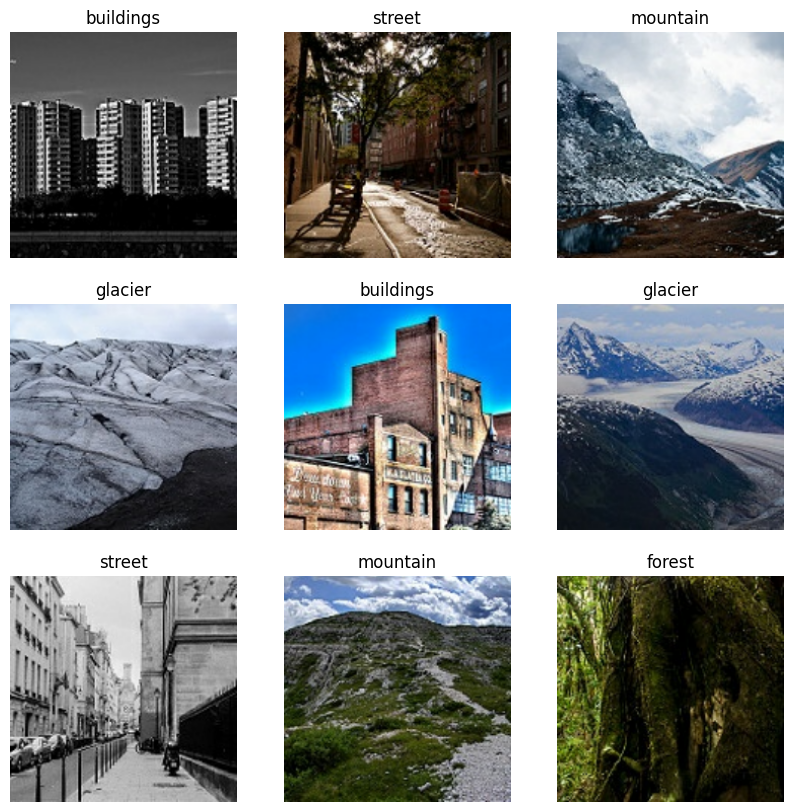

In [4]:
# Sección 6: Visualizar imágenes del dataset de entrenamiento
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

In [5]:
# Sección 7: Verificar forma de un batch
for images, labels in train_dataset.take(1):
    print("Shape of image batch:", images.shape)
    print("Shape of label batch:", labels.shape)

Shape of image batch: (16, 224, 224, 3)
Shape of label batch: (16,)


In [6]:
# Sección 6: Construir el modelo CNN con regularización y Dropout
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(6, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,054 (98.37 MB)

 Trainable params: 25,785,606 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
# Sección 7: Compilar y entrenar el modelo con Data Augmentation
from tensorflow.keras.optimizers import Adam

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),  # Rotación aleatoria hasta 20%
    RandomZoom(0.2)  # Zoom aleatorio hasta 20%
])

augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Compilar el modelo con optimizador ajustado
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ajustar EarlyStopping
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 206s 218ms/step - accuracy: 0.5086 - loss: 1.4328 - val_accuracy: 0.6250 - val_loss: 0.9980
Epoch 2/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 190s 216ms/step - accuracy: 0.6063 - loss: 1.0303 - val_accuracy: 0.6496 - val_loss: 0.9310
Epoch 3/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 197s 211ms/step - accuracy: 0.6463 - loss: 0.9526 - val_accuracy: 0.6786 - val_loss: 0.8846
Epoch 4/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 202s 210ms/step - accuracy: 0.6573 - loss: 0.9184 - val_accuracy: 0.6797 - val_loss: 0.8714
Epoch 5/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 200s 208ms/step - accuracy: 0.6783 - loss: 0.8778 - val_accuracy: 0.6998 - val_loss: 0.8361
Epoch 6/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 205s 212ms/step - accuracy: 0.6907 - loss: 0.8410 - val_accuracy: 0.7143 - val_loss: 0.7929
Epoch 7/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 201s 210ms/step - accuracy: 0.6981 - loss: 0.8082 - val_accuracy: 0.7254 - val_loss: 0.7628
Epoch 8/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 186s 212ms/step - accuracy: 

In [8]:
# Sección 10: Evaluación del modelo en el conjunto de entrenamiento
train_loss, train_acc = model.evaluate(train_dataset)
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Training Loss: {train_loss:.3f}")

878/878 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8767 - loss: 0.3354
Training Accuracy: 0.881
Training Loss: 0.325


In [ ]:
# Sección 11: Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")


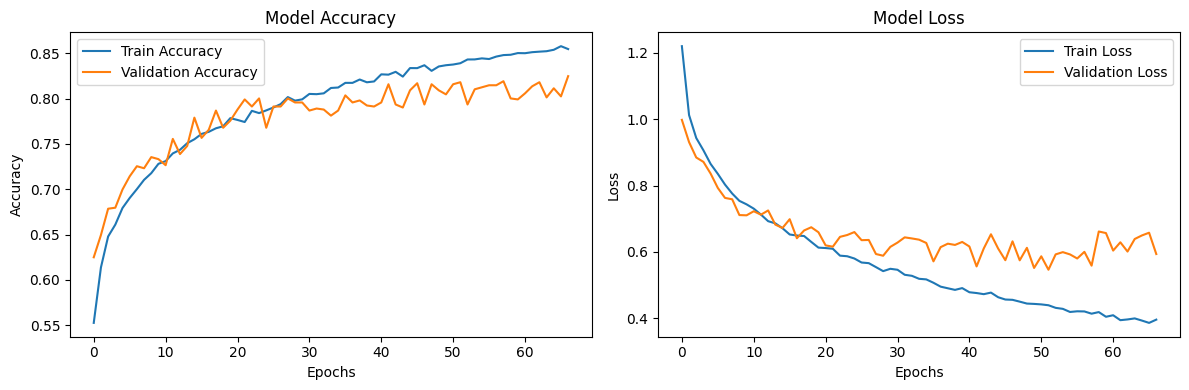

In [10]:
# Sección 12: Visualización de métricas
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model

# Subir hasta 6 imágenes
uploaded = files.upload()

# Verificar si se cargaron imágenes
if len(uploaded) > 0:
    # Lista para almacenar las imágenes preprocesadas
    batch_images = []

    for i, filename in enumerate(uploaded.keys()):
        if i >= 6:  # Limitar a 6 imágenes
            break

        # Cargar la imagen
        img_path = filename  # Nombre del archivo cargado
        img = image.load_img(img_path, target_size=(224, 224))  # Redimensionar la imagen
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Imagen Cargada: {filename}")
        plt.show()

        # Preprocesar la imagen
        img_array = image.img_to_array(img)  # Convertir a array
        img_array = img_array / 255.0  # Normalizar al rango [0, 1]
        batch_images.append(img_array)

    # Convertir la lista en un numpy array para predicción en batch
    batch_images = np.array(batch_images)

    # Realizar predicciones
    predictions = model.predict(batch_images)

    # Mostrar resultados para cada imagen
    for i, prediction in enumerate(predictions):
        predicted_class = np.argmax(prediction)
        confidence = prediction[predicted_class]

        print(f"Imagen: {list(uploaded.keys())[i]}")
        print(f"Predicción: {class_names[predicted_class]}")
        print(f"Confianza: {confidence:.2f}")
        print("-" * 30)
else:
    print("No se cargaron imágenes.")
